# **Mount Colab to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Business Problem**

Cancer is one of the leading causes of death globally and it is responsible for 9.6 million deaths a year. One of the most deadliest type of cancer is brain cancer, the 5-years survival rate is 34% for men and 36% for women.

There are three types of brain tumors menigioma, pituitray and glioma.
the type of the tumor can be an indication of the tumor‘s aggressiveness,
however to estimate the tumor’s stage (the size of the cancer and how
far it’s spread) an expert needs to segment the tumor first in order to
measure it in an accurate way.

The screening process (the process of performing MRI or CT scans
to detect tumors) can be devided to two main tasks.

 The  **first task** is the classification task, doctors need to identify the type of the brain tumor.

The **second task** is tumor segmenation.

**Solution:**

1) Develop automatic, accurate multimodal machine learning classification for brain tumors.


2) Develop automatic, accurate brain tumor segmentation model.








# **Import Libaries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, jaccard_similarity_score
from google.colab import drive
import time
import platform
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image


Pytorch version

In [ ]:

torch.__version__

'1.8.1+cu101'

Check GPU

In [ ]:
!nvidia-smi

Mon May 31 18:02:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


Empty GPU's memory/cache for training so we'd clear garbage values in it and more memory will be available

In [ ]:
torch.cuda.empty_cache()

# **Dataset Class**

Create a custom dataset class that augments each image into 4 different angles: 0, 45, 90, 120, 180, 270, 300, 330 degrees. Fuse it with Pytorch's DataLoader class so data can be loaded, augmented and trained in realtime instead of caching all training samples in memory for augmenting.

In [ ]:
class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels
    
    # Transformation for converting original image array to an image and then convert it to a tensor
    self.transform = transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -45 degrees and 45 degrees, and then convert it to a tensor
    self.transform1 = transforms.Compose([
        transforms.ToPILImage(),                                          
        transforms.RandomRotation(45),
        transforms.ToTensor()                                 
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -90 degrees and 90 degrees, and then convert it to a tensor
    self.transform2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(90),
        transforms.ToTensor()                                  
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -120 degrees and 120 degrees, and then convert it to a tensor
    self.transform3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(120),
        transforms.ToTensor()                                  
    ])

     # Transformation for converting original image array to an image, rotate it randomly between -180 degrees and 180 degrees, and then convert it to a tensor
    self.transform4 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(180),
        transforms.ToTensor()                                
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -270 degrees and 270 degrees, and then convert it to a tensor
    self.transform5 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(270),
        transforms.ToTensor()                                
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -300 degrees and 300 degrees, and then convert it to a tensor
    self.transform6 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(300),
        transforms.ToTensor()                               
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -330 degrees and 330 degrees, and then convert it to a tensor
    self.transform7 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(330),
        transforms.ToTensor()                                 
    ])

  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # Original image as a tensor
    data = self.transform(self.X[idx])

    # Augmented image at 45 degrees as a tensor
    aug45 = self.transform1(self.X[idx])

    # Augmented image at 90 degrees as a tensor
    aug90 = self.transform2(self.X[idx])

    # Augmented image at 120 degrees as a tensor
    aug120 = self.transform3(self.X[idx])

    # Augmented image at 180 degrees as a tensor
    aug180 = self.transform4(self.X[idx])

    # Augmented image at 270 degrees as a tensor
    aug270 = self.transform5(self.X[idx])

    # Augmented image at 300 degrees as a tensor
    aug300 = self.transform6(self.X[idx])

    # Augmented image at 330 degrees as a tensor
    aug330 = self.transform7(self.X[idx])      
    
    # store the transformed images in a list
    new_batch = [data, aug45, aug90, aug120, aug180, aug270, aug300, aug330]

    # one-hot encode the labels
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0

    new_labels = [labels, labels, labels, labels, labels, labels, labels, labels]

    # 8 augmented images and corresponding labels per sample will be returned
    return (torch.stack(new_labels), torch.stack(new_batch))

# **Load Dataset**



In [ ]:
training_data = pickle.load(open('/content/drive/My Drive/Project/new_dataset/training_data.pickle', 'rb'))

In [ ]:
# Create empty lists for storing  data
Xt = []
yt = []
features = None
labels = None
label = []

# Store images in Xt and labels in yt iteratively
for features,labels in training_data:
  Xt.append(features)
  yt.append(labels)


# **Train Validation Test split**

Split the dataset for training using cross-validation method.

70 % of images for training
15% of images for validating
15% of images for testing

In [ ]:
# 70 % training, 15% validating, 15% testing
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.3, shuffle=True)  # 70% training, 30% testing
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)  # split testing set into 50% validation , 50% testing

In [ ]:
# Empty the previously used lists and arrays to free up RAM / Cache
Xt = None
yt = None
features = None
labels = None
label = None
training_data = None


In [ ]:
# Create training set, validation set and test set using our custom dataset class

train_set = BrainTumorDataset(X_train, y_train)
valid_set = BrainTumorDataset(X_valid, y_valid)
test_set = BrainTumorDataset(X_test, y_test)

# Print original number of samples in each set
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_valid)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 2144
Number of validation samples: 460
Number of testing samples: 460


# **Data Augmentation**

In [ ]:
# Print augmented number of samples in each set
print(f"Number of augmented training samples: {len(X_train) * 8}")
print(f"Number of augmented validation samples: {len(X_valid)* 8}")
print(f"Number of augmented testing samples: {len(X_test)* 8}")

Number of augmented training samples: 17152
Number of augmented validation samples: 3680
Number of augmented testing samples: 3680


## **Data Loader**

In [ ]:
# Create a DataLoader for each set with batch size of 4 and shuffling enabled
train_gen = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
valid_gen = DataLoader(valid_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
test_gen = DataLoader(test_set, batch_size=10, shuffle=True, pin_memory=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
# Get device to set the training to run on GPU or CPU later based on its availability
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CUDA_LAUNCH_BLOCKING=1

# **RESNET 50 Model **


# **Build Model**

Instantiate the transfer learning model using torchvision's models class.

RESNET50 is the CNN model that we're going to use by transfer learning.

Set all the pretrained weights to trainable by enabling every layer's parameters as true

Build the top layer by creating a custom output sequential layer and assign it to model's fc.

In [ ]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all paramters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 4),
                                nn.LogSigmoid())

# set all paramters of the model as trainable
for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Training Configuration**

Set model's loss function as CrossEntropyLoss

Set SGD optimizer with 0.9 momentum and learning rate 3e-4 as the model's optimizer.

Run the model for 50 total iterations

Create empty lists to store training losses, validation losses, training accuracies, and validation accuracies.


In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=3e-4)

# number of training iterations
epochs = 50

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# **Checkpoint Saver**

A function to save the model using checkpoints based on best loss achieved during every iteration compared with previous iteration's loss. We'll load the checkpoint and resume training in case Colab's runtime get's disconnected due to inactivity or any other issues.

In [ ]:
def save_checkpoint(state, is_best, filename='/content/drive/My Drive/bt_resnet50_ckpt_v1.pth.tar'):
    torch.save(state, filename)

# **Train Model**

In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_gen):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)

        # forward pass image sample
        y_pred = resnet_model(X.view(-1, 3, 512, 512))
        # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(32, 4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*4}\nAccuracy: {trn_corr.item()*100/(4*8*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(valid_gen):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)

            # forward pass image
            y_val = resnet_model(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(32, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(4*8*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': resnet_model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Batch 2144
Accuracy: 53.72 %  Loss: 0.3618  Duration: 7.09 minutes
Validation Accuracy 76.62 Validation Loss: 0.5079

Epoch 2 Batch 2144
Accuracy: 77.49 %  Loss: 0.7215  Duration: 7.08 minutes
Validation Accuracy 82.26 Validation Loss: 0.2121

Epoch 3 Batch 2144
Accuracy: 83.95 %  Loss: 0.1742  Duration: 7.08 minutes
Validation Accuracy 87.23 Validation Loss: 0.0480

Epoch 4 Batch 2144
Accuracy: 87.71 %  Loss: 0.4467  Duration: 7.08 minutes
Validation Accuracy 86.16 Validation Loss: 0.0559

Epoch 5 Batch 2144
Accuracy: 89.33 %  Loss: 0.0847  Duration: 7.08 minutes
Validation Accuracy 90.08 Validation Loss: 1.5380

Epoch 6 Batch 2144
Accuracy: 90.65 %  Loss: 0.1988  Duration: 7.07 minutes
Validation Accuracy 89.75 Validation Loss: 0.2219

Epoch 7 Batch 2144
Accuracy: 93.36 %  Loss: 0.3635  Duration: 7.07 minutes
Validation Accuracy 92.60 Validation Loss: 0.7898

Epoch 8 Batch 2144
Accuracy: 93.62 %  Loss: 0.0097  Duration: 7.07 minutes
Validation Accuracy 92.19 Validation Loss: 

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
torch.cuda.empty_cache()

# **Save Model**

In [ ]:
torch.save(resnet_model.state_dict(), '/content/drive/My Drive/Project/bt_resnet50_model_v3.pt')

# **Data Evaluation**

In [ ]:
# Print the validation accuracy of the model calculated using validation set during training
print(f'Validation accuracy: {test_correct[-1].item()*100/(test_b*8*4):.2f}%')


Validation accuracy: 98.90%


# **Loss Graph**

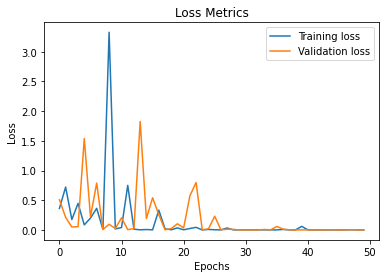

In [ ]:
# Plot  Loss Graph
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# **Accuracy Graph**

Training set - Total length of training samples divided by 100 for every trained sample

int((2144 * 8)/100) = int(171.52) = 171
Testing set - Total length of testing samples divided by 100 for every testing sample

int((460 * 8)/100) = int(36.8) = 36

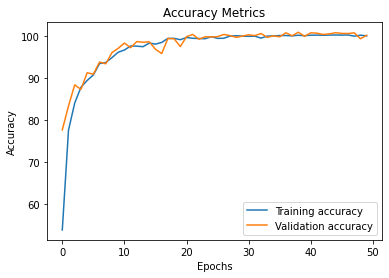

In [ ]:
# plot Accuracy Graph
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


In [ ]:
# Empty out training set and validation set to free up RAM / Cache
train_gen = None
valid_gen = None
train_set = None
valid_set = None

Calculate loss, correctly classified samples, predicted values, labels and store them in a list using test dataloader

In [ ]:
# set model to evaluation mode
resnet_model.eval()

# perform no gradient updates
with torch.no_grad():
    # soem metrics storage for visualization and analysis
    correct = 0
    test_loss = []
    test_corr = []
    labels = []
    pred = []
    # perform test set evaluation batch wise
    for (y, X) in test_gen:
        # set label to use CUDA if available
        X, y = X.to(device), y.to(device)

        # append original labels
        labels.append(torch.argmax(y.view(10 * 8, 4), dim=1).data)

        # perform forward pass
        y_val = resnet_model(X.view(-1, 3, 512, 512))

        # get argmax of predicted values, which is our label
        predicted = torch.argmax(y_val, dim=1).data
        # append predicted label
        pred.append(predicted)

        # calculate loss
        loss = criterion(y_val.float(), torch.argmax(y.view(10 * 8, 4), dim=1).long())

        # increment correct with correcly predicted labels per batch
        correct += (predicted == torch.argmax(y.view(10 * 8, 4), dim=1)).sum()

        # append correct samples labels and losses
        test_corr.append(correct)
        test_loss.append(loss)
        
print(f"Test Loss: {test_loss[-1].item():.4f}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Loss: 0.1046


# **Test Accuracy**

In [ ]:
print(f'Test accuracy: {test_corr[-1].item()*100/(460*8):.2f}%')

Test accuracy: 98.99%


Convert list of tensors to tensors

In [ ]:
labels = torch.stack(labels)
pred = torch.stack(pred)

In [ ]:
# Define ground-truth labels as a list
LABELS = ['Meningioma', 'Glioma', 'Pitutary']

# **Confusion Matrix**

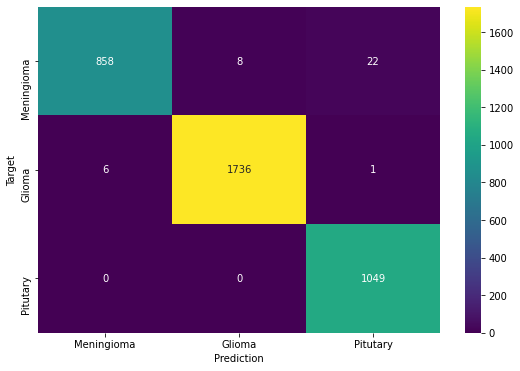

In [ ]:
arr = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

# **Classification Report**

In [ ]:
print(f"Clasification Report\n\n{classification_report(pred.view(-1).cpu(), labels.view(-1).cpu())}")

Clasification Report

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       888
           2       1.00      1.00      1.00      1743
           3       0.98      1.00      0.99      1049

    accuracy                           0.99      3680
   macro avg       0.99      0.99      0.99      3680
weighted avg       0.99      0.99      0.99      3680



# **Test Data**

In [ ]:
path_image_tested='/content/drive/My Drive/Project/new_dataset/images/2.jpg'

In [ ]:
resnet_model.to(device)


resnet_model.load_state_dict(torch.load('/content/drive/My Drive/Project/bt_resnet50_model_v2.pt'))

resnet_model.eval()

transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])

LABELS = ['None', 'Meningioma', 'Glioma', 'Pitutary']

img_name = input("Enter path to the image: ")

if not os.path.exists(img_name):
    print("File does not exits. Exiting...\n")
    exit()

img = Image.open(img_name)

img = transform(img)

img = img[None, ...]

with torch.no_grad():
    y_hat = resnet_model.forward(img.to(device))

    predicted = torch.argmax(y_hat.data, dim=1)

    print(LABELS[predicted.data],'\n')

Enter path to the image: /content/drive/My Drive/Project/new_dataset/images/2.jpg
Meningioma 



# **Vgg16 Model**

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.


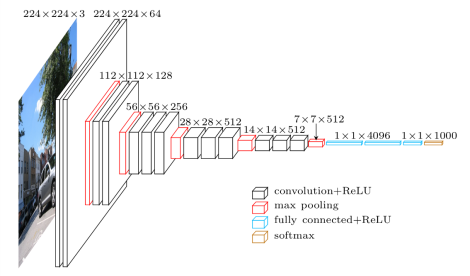


# **Vgg16 Model: Build Model**

In [ ]:
# instantiate transfer learning model
vgg16_model =  models.vgg16(pretrained=True)

# set all paramters as trainable
for param in vgg16_model.parameters():
    param.requires_grad = True



# redefine fc layer / top layer/ head for our classification problem
gap = nn.AdaptiveAvgPool2d((1, 1))
first_fc_layer=nn.Linear(512, 1024)
second_fc_layer=nn.Linear(1024, 1024)
last_fc_layer=nn.Linear(1024, 4)
do1=torch.nn.Dropout(p=0, inplace=False)
do2=torch.nn.Dropout(p=0, inplace=False)

vgg16_model.avgpool = gap
vgg16_model.classifier[0]=first_fc_layer
vgg16_model.classifier[3]=second_fc_layer
vgg16_model.classifier[6]=last_fc_layer
vgg16_model.classifier[2]=do1
vgg16_model.classifier[5]=do2

# set all paramters of the model as trainable
for name, child in vgg16_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
vgg16_model.to(device)

# print the trasnfer learning NN model's architecture
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print("python version:", platform.python_version())
print("torch version:", torch.__version__)
print("torch cuda:", torch.cuda.is_available())
print("torch cuda version", torch.version.cuda)

python version: 3.7.10
torch version: 1.8.1+cu101
torch cuda: True
torch cuda version 10.1


# **Vgg16 Model: Training Configuration**

In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(vgg16_model.parameters(), momentum=0.9, lr=1e-4)

# number of training iterations
epochs = 50

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# **Checkpoint Saver**

In [ ]:
def save_checkpoint(state, is_best, filename='/content/drive/My Drive/bt_vgg16_v1.pth.tar'):
    torch.save(state, filename)

# **Vgg16 Model: Train Model**

In [ ]:
CUDA_LAUNCH_BLOCKING=1
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_gen):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)

        # forward pass image sample
        y_pred = vgg16_model(X.view(-1, 3, 512, 512))
        # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(32, 4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*4}\nAccuracy: {trn_corr.item()*100/(4*8*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(valid_gen):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)

            # forward pass image
            y_val = vgg16_model(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(32, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(4*8*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': vgg16_model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Batch 2144
Accuracy: 43.98 %  Loss: 1.0702  Duration: 11.99 minutes
Validation Accuracy 49.34 Validation Loss: 0.9514

Epoch 2 Batch 2144
Accuracy: 65.85 %  Loss: 1.3572  Duration: 11.97 minutes
Validation Accuracy 53.81 Validation Loss: 1.2379

Epoch 3 Batch 2144
Accuracy: 79.12 %  Loss: 0.7259  Duration: 11.99 minutes
Validation Accuracy 85.25 Validation Loss: 0.9727

Epoch 4 Batch 2144
Accuracy: 82.90 %  Loss: 0.5940  Duration: 11.98 minutes
Validation Accuracy 76.01 Validation Loss: 0.0778

Epoch 5 Batch 2144
Accuracy: 83.74 %  Loss: 0.4235  Duration: 11.98 minutes
Validation Accuracy 82.29 Validation Loss: 0.3414

Epoch 6 Batch 2144
Accuracy: 84.30 %  Loss: 0.9691  Duration: 11.99 minutes
Validation Accuracy 86.02 Validation Loss: 0.0026

Epoch 7 Batch 2144
Accuracy: 86.15 %  Loss: 0.0141  Duration: 11.98 minutes
Validation Accuracy 80.73 Validation Loss: 0.0107

Epoch 8 Batch 2144
Accuracy: 85.88 %  Loss: 0.4391  Duration: 11.99 minutes
Validation Accuracy 86.32 Validatio

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


# **Vgg16 Model: Save Model**

In [ ]:
torch.save(vgg16_model.state_dict(), '/content/drive/My Drive/Project/bt_vgg16_model_v1.pt')

# **Data Evaluation**

In [ ]:
# Print the validation accuracy of the model calculated using validation set during training
print(f'Validation accuracy: {test_correct[-1].item()*100/(test_b*8*4):.2f}%')


Validation accuracy: 97.12%


# **Loss Graph**

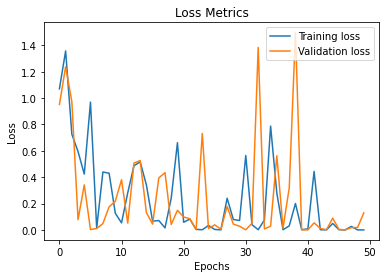

In [ ]:
# Plot  Loss Graph
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# **Accuracy Graph**

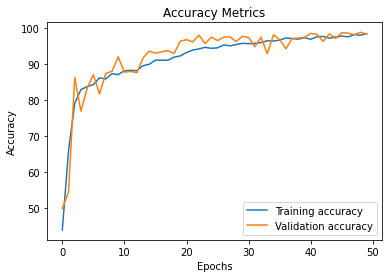

In [ ]:
# plot Accuracy Graph
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


# **Test Accuracy**

In [ ]:
# Empty out training set and validation set to free up RAM / Cache
train_gen = None
valid_gen = None
train_set = None
valid_set = None

In [ ]:
# set model to evaluation mode
vgg16_model.eval()

# perform no gradient updates
with torch.no_grad():
    # soem metrics storage for visualization and analysis
    correct = 0
    test_loss = []
    test_corr = []
    labels = []
    pred = []
    # perform test set evaluation batch wise
    for (y, X) in test_gen:
        # set label to use CUDA if available
        X, y = X.to(device), y.to(device)

        # append original labels
        labels.append(torch.argmax(y.view(10 * 8, 4), dim=1).data)

        # perform forward pass
        y_val = vgg16_model(X.view(-1, 3, 512, 512))

        # get argmax of predicted values, which is our label
        predicted = torch.argmax(y_val, dim=1).data
        # append predicted label
        pred.append(predicted)

        # calculate loss
        loss = criterion(y_val.float(), torch.argmax(y.view(10 * 8, 4), dim=1).long())

        # increment correct with correcly predicted labels per batch
        correct += (predicted == torch.argmax(y.view(10 * 8, 4), dim=1)).sum()

        # append correct samples labels and losses
        test_corr.append(correct)
        test_loss.append(loss)
        
print(f"Test Loss: {test_loss[-1].item():.4f}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Loss: 0.1679


In [ ]:
print(f'Test accuracy: {test_corr[-1].item()*100/(460*8):.2f}%')

Test accuracy: 97.12%


# **Confusion Matrix**

In [ ]:
labels = torch.stack(labels)
pred = torch.stack(pred)

In [ ]:
# Define ground-truth labels as a list
LABELS = ['Meningioma', 'Glioma', 'Pitutary']

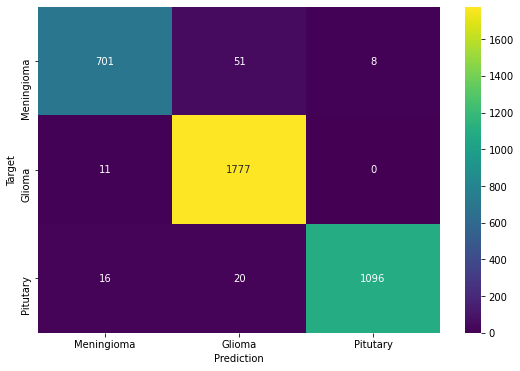

In [ ]:
arr = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

# **Classification Report**

In [ ]:
print(f"Clasification Report\n\n{classification_report(pred.view(-1).cpu(), labels.view(-1).cpu())}")

Clasification Report

              precision    recall  f1-score   support

           1       0.96      0.92      0.94       760
           2       0.96      0.99      0.98      1788
           3       0.99      0.97      0.98      1132

    accuracy                           0.97      3680
   macro avg       0.97      0.96      0.97      3680
weighted avg       0.97      0.97      0.97      3680



# **Test Data**

In [ ]:
path_image_tested='/content/drive/My Drive/Project/new_dataset/images/2.jpg'

In [ ]:
vgg16_model.to(device)

vgg16_model.eval()

transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])

LABELS = ['None', 'Meningioma', 'Glioma', 'Pitutary']

img_name = input("Enter path to the image: ")

if not os.path.exists(img_name):
    print("File does not exits. Exiting...\n")
    exit()

img = Image.open(img_name)

img = transform(img)

img = img[None, ...]

with torch.no_grad():
    y_hat = vgg16_model.forward(img.to(device))

    predicted = torch.argmax(y_hat.data, dim=1)

    print(LABELS[predicted.data],'\n')

Enter path to the image: /content/drive/My Drive/Project/new_dataset/images/2.jpg
Meningioma 



# **Business Value**

The early detection of tumors and the precise identification of the tupe of tumors can target the appropraie treatment which can be :

1) efficient

2) fast detection

3) fast identification

4) Appropriate treatment

5) Save lives

The RESNET50 is CNN Model with high accuracy:

It can identify pituitary tumor with 0 false negative.

It can identify glioma tumor with 0.2% false negative.

It can identify miningioma tumor with 0.9% false negative.

# **Conclusion**

Both RESNET50 and vgg16 performed good for the multimodal classification of brain tumors.

RESTNET50 model has 99-100% recall, among which 98-100% are true brain tumors.

# **Future Work**

Model can be deployed using python flask server as a website, so anyone could an upload MRI image of brain and find out what kind tumor is present.

Add more sophisticated regularization techniques to prevent slight overfitting and increase accuracy up to 100 %.

Develop one machine learning model for the detction, identification and segmentation of brain tumor.